In [1]:
# for colab
# !pip install pytorch-lightning
# !pip install mne
# !pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import mne
dataset_path = '~/Documents/Github/eeg_tutorial' # set where you want your mne datasets to go
mne.set_config('MNE_DATA', dataset_path)

In [2]:
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
# import pandas as pd
import matplotlib.pyplot as plt
# import numpy as np
import mne
from pathlib import Path
import os
from mne.datasets import eegbci
import matplotlib


#  data preprocessing with MNE

link here:
http://learn.neurotechedu.com/preprocessing/

## Importing the data

The primary image format for MNE is FIF (functional imaging file format). We're going to use one of the mne datasets, and we'll just practice working through an unfamiliar directory to find what we're looking for.

In [4]:
#WARNING, DO NOT RUN IF ALREADY LOCAL, FOR COLAB PURPOSES
# #built in data file, somatosensory data
#mne.datasets.somato.data_path() # half gig file download

In [5]:
#if running for first time and unfamiliar with files 
# base_path = mne.datasets.somato.data_path()

# # we'll make a list of every .fif file we can find
# fif_files = list(base_path.rglob('*.fif')) # '*' is our wildcard character
# for file in fif_files: #lets print out what we have and see where our meg file is
#   print(file)

In [6]:

raw = mne.io.read_raw_fif('~/Documents/Github/eeg_tutorial/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif')

Opening raw data file ~/Documents/Github/eeg_tutorial/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.


**MNE has built in plotting, let's take a visual look at the raw data**



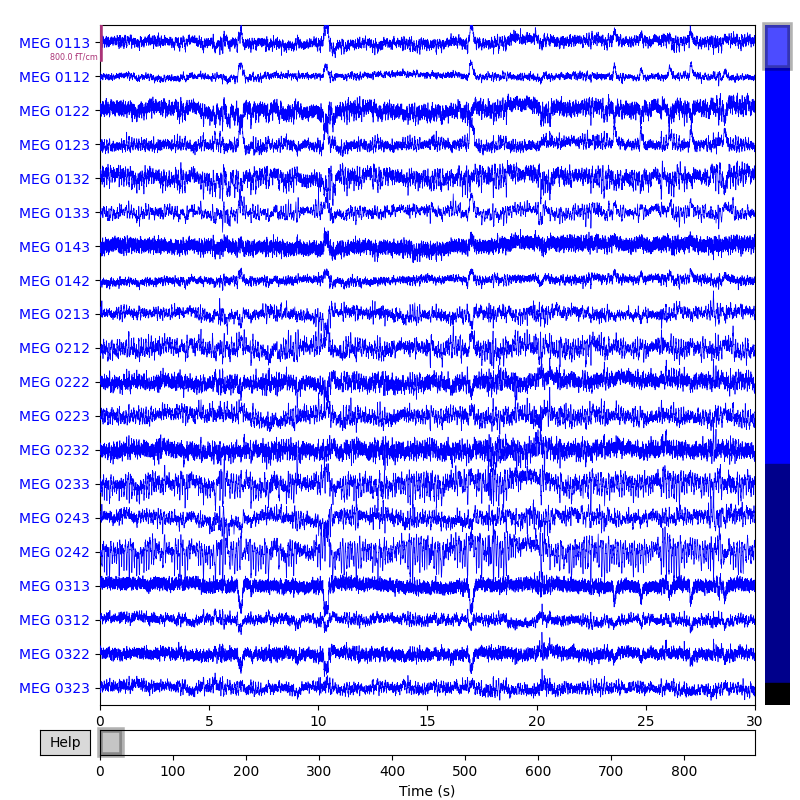

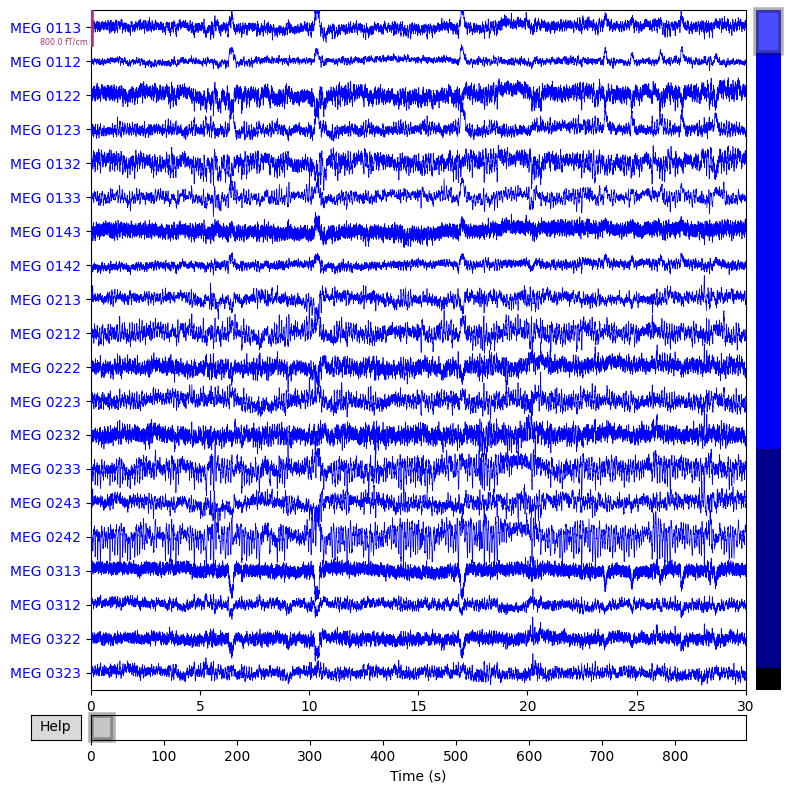

In [8]:
%matplotlib widget
raw.plot(duration = 30, block = True)


**This raw file will have a dictionary of the metadata, we can get a simple output with .info, or go through the dictionary and see what we have. If you know there's a specific piece of metadata you're after, use .get()**


In [23]:
raw.info

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 1 10.000000 8040.000000 1 10.000000 8233.000000 1 10.000000 ...
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 1 EOG
 custom_ref_applied: False
 description: Kainulainen (jarika) VectorView system at HUT
 dev_head_t: MEG device -> head transform
 dig: 47 items (3 Cardinal, 4 HPI, 40 Extra)
 events: 1 item (list)
 experimenter: Jari
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 100.1 Hz
 meas_date: 2007-07-05 11:17:11 UTC
 meas_id: 4 items (dict)
 nchan: 316
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: particles
 projs: []
 sfreq: 300.3 Hz
 subject_info: 2 items (dict)
>

In [24]:
info_keys = raw.info.keys() # lets see everything we're working with
for item in info_keys:
  print(item)

file_id
events
hpi_results
hpi_meas
subject_info
device_info
helium_info
hpi_subsystem
proc_history
meas_id
experimenter
description
proj_id
proj_name
meas_date
utc_offset
sfreq
highpass
lowpass
line_freq
gantry_angle
chs
dev_head_t
ctf_head_t
dev_ctf_t
dig
bads
ch_names
nchan
projs
comps
acq_pars
acq_stim
custom_ref_applied
xplotter_layout
kit_system_id


In [25]:
raw.info.get('nchan') # let's look at how many channels we have

316

In [26]:
#we'll get a sense of the data now.
raw.get_data().shape

(316, 269400)

**As we saw in the plot above we have rows that make up the 316 channels, and we'll have 269400 recordings for each of those channels.**

## Working with EEGBCI

In [9]:
#To download dataset

#we'll set up the subject and runs we want. We'll just deal with one run for now
#Note that load_data will return a list object. This list will contain all of the

# subject = 1
# runs = [4]

# raw_path = eegbci.load_data(subject, runs, path= None)[0] # this always returns a list of runs, so just take out the first(only) run

# raw = mne.io.read_raw_edf(raw_path, preload= True)


/Users/freymonperez/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Do you want to set the path:
    /Users/freymonperez/Documents/Github/eeg_tutorial
as the default EEGBCI dataset path in the mne-python config [y]/n?  y


Download complete in 16s (2.5 MB)
Extracting EDF parameters from /Users/freymonperez/Documents/Github/eeg_tutorial/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [10]:
raw.get_data().shape

(64, 20000)

**This tell us we're looking at 64 electrodes, and 20,000 is our temporal component. EEGs take multiple samples per second, each data point is whatever the voltage was at that particular electrode, at that exact moment.  So lets find out how many samples we're taking a second. We can do this easily like before, it's a part of the meta data in** `.info`

In [11]:
raw.info.get('sfreq')

160.0

raw.info.get('nchan')

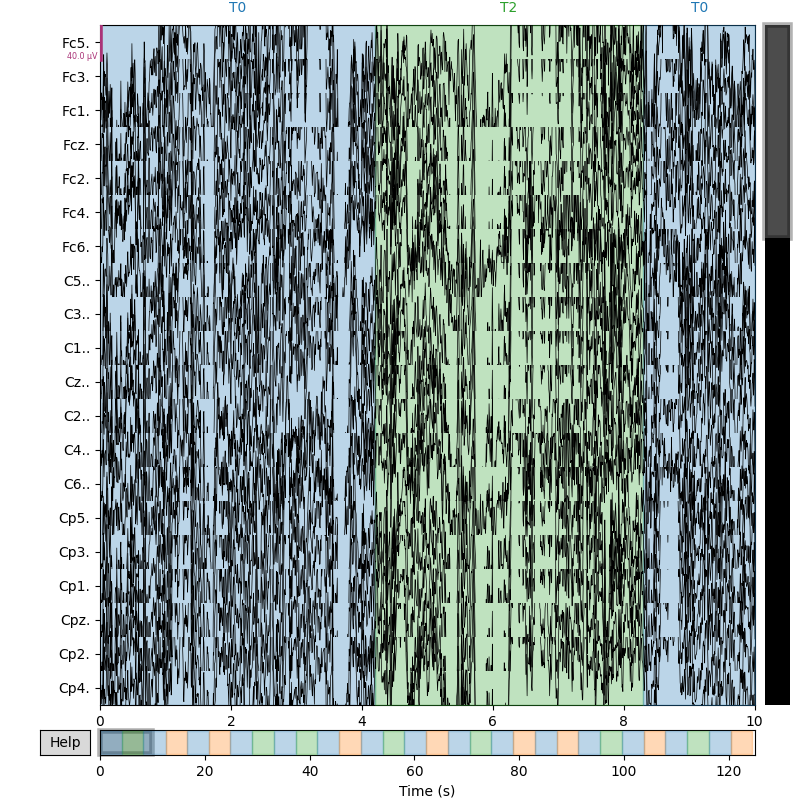

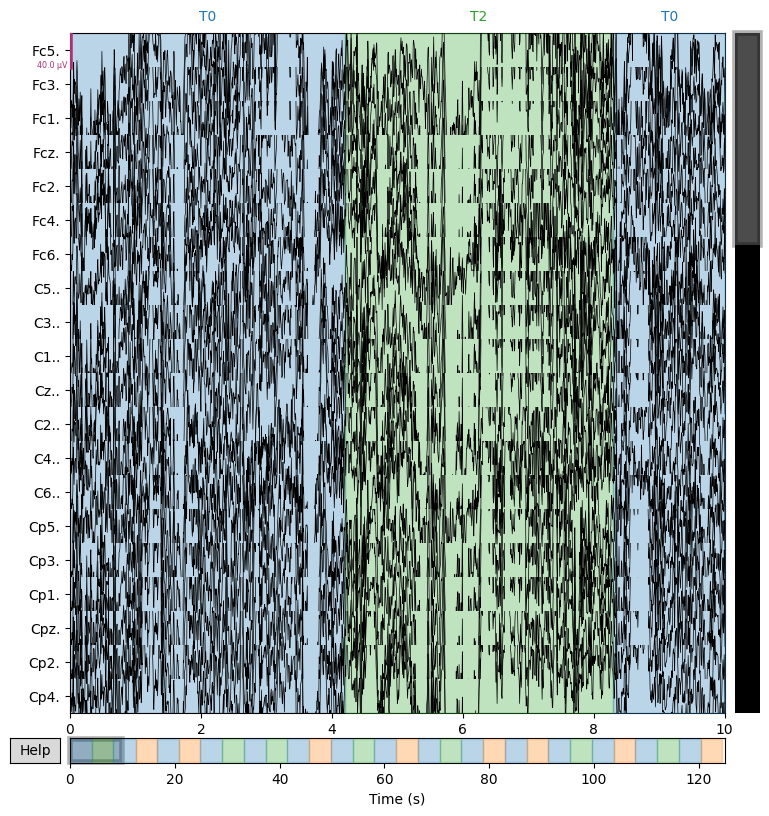

In [12]:
#let's plot again
raw.plot( block = True)

Now you can visually inspect each channel and manually remove any obviously problematic channels. Beyond that there are some computational methods that we can leverage.

* Z-scores/STD- These statistical methods can help us to find any channel that wildly deviates (think 3 or more STDs) from the norm
* We can achieve similar results by simply creating thresholds for the amplitute. Identify max and min values, and take anything above and beyond to be unreasonably extreme.
* It is also possible that a channel somehow picks up nothing at all, you could similarly remove channels whose voltage shows little to no variation.

There are, of course, many more advanced methods to explore. eeglab is a good resource for this: 
https://eeglab.org/tutorials/06_RejectArtifacts/Channel_rejection.html

